# Package Definitions

In [1]:
## Package for Preferential Attachment Model with Delay
## By Charles Cooper and Partha Dey

## This model generates graphs from Preferential Attachment Model with Delay 
## where at any time t, m edges are created based on graph at time (t - delay_t)_+ 
## with edge probability proportional to (degree + delta)
## For the no delay model, the exponent for the Asymptotic Degree distribution should be $ 3 + \delta/m $

## Load packages as needed
import numpy as np
import networkx as nx
from networkx.utils import py_random_state
import matplotlib.pyplot as plt
import random, time, math
import matplotlib.ticker as ticker

In [2]:
## Auxiliary functions for plot axis labels
def pow10(x, pos):
    """The two arguments are the value and tick position."""
    return '$10^{'+'{:1.1f}'.format(x)+'}$'


In [3]:
## Taken from np random graph generator 
## fastest with integer computations
## Return m unique elements from seq.
## Note: rng is a random.Random or numpy.random.RandomState instance.

def _random_subset(seq, m, rng):
    targets = set()
    while len(targets) < m:
        x = rng.choice(seq)
        targets.add(x)
    return targets

In [4]:
## This can take cumulative weights
## two times slower then _random_subset
## with floating point computations
## Return m unique elements from seq.
## Note: rng is a random.Random or numpy.random.RandomState instance."""

def _random_subset_pr(seq, m, cweight, rng):
    targets = []
    while len(targets) < m:
        x = rng.choices(seq, cum_weights=cweight, k=1)
        targets.extend(x)
    return targets

In [5]:
## Functions to generate one sample from Preferential Attachment model with Delay

## PA(N, m, Delta) - No delay, integer Delta
@py_random_state(5)
def pa(n, m, delta=0, dela=1, G0=None, seed=None):
    # DELTA must be a non-negative integer
    if G0==None:
        G = nx.star_graph(m)
    else:
        G = G0.copy()
    repeated_nodes = [i for (i, d) in G.degree() for _ in range(d + delta) ]
    source = len(G)
    while source < n:
        # Now choose m unique nodes from the existing nodes
        # Pick uniformly from repeated_nodes (preferential attachment)
        targets = _random_subset(repeated_nodes, m, seed)
        # Add edges to m nodes from the source.
        G.add_edges_from(zip([source] * m, targets))
        # Add one node to the list for each new edge just created.
        repeated_nodes.extend(targets)
        # And the new node "source" has m edges to add to the list.
        repeated_nodes.extend([source] * (m+delta))
        source += 1
    return G

## PAD(N,m,Delta=0,Delay=1) - With Delay, integer Delta
@py_random_state(5)
def pad(n, m, delta=0, dela=1, G0=None, seed=None):
    """Return random graph using preferential attachment model with delay.
    Delta must be an integer for this program"""
    # Process the delay to get connection nodes
    if type(dela)==int: 
        delay = np.maximum(range(n) - dela, 0)
    else:
        delay = np.maximum(range(n) - dela.astype(int), 0)
    if G0==None:
        G = nx.star_graph(m)
    else:
        G = G0.copy()
    repeated_nodes = [i for (i, d) in G.degree() for _ in range(d + delta) ]
    pos = [len(repeated_nodes) for _ in G.nodes()]
    targets = _random_subset(repeated_nodes, m, seed)
    source = len(G)
    while source<n:
        # Add edges to m nodes from the source.
        G.add_edges_from(zip(targets,[source] * m))
        # Add one node to the list for each new edge just created.
        repeated_nodes.extend(targets)
        # And the new node "source" has m edges to add to the list.
        repeated_nodes.extend([source] * (m + delta))
        pos.extend([pos[-1]+2*m+delta])
        # Now choose m unique nodes from the existing nodes
        # Pick uniformly from repeated_nodes (preferential attachement)
        ds = delay[source]
        posds = pos[ds]
        if ds==source-1:
            targets = _random_subset(repeated_nodes, m, seed)
        else:
            targets = _random_subset(repeated_nodes[:posds], m, seed)
        source += 1
    return G

## PADGEN(N,m,Delta=0,Delay=1) - With Delay, real Delta
@py_random_state(5)
def padgen(n, m, delta=0, dela=1, G0=None, seed=None):
    """Return random graph using preferential attachment model with delay.
    Delta can be any real number > -1 for this program"""
    # Process the delay to get connection nodes
    if type(dela)==int: 
        delay = np.maximum([i-dela for i in range(n)], 0)
    else:
        delay = np.maximum(range(n) - dela.astype(int), 0)
    if G0==None:
        G = nx.star_graph(m)
    else:
        G = G0.copy()
    repeated_nodes = [k for (k, d) in G.degree()]
    cweight_nodes = list(np.cumsum([d for (k, d) in G.degree()]))
    pos = [len(G) for _ in G.nodes()]
    # Start adding the other n-m0 nodes. The first node is m.
    targets = _random_subset_pr(repeated_nodes, m, cweight_nodes, seed)
    source = len(G)
    while source<n:
        # Add edges to m nodes from the source.
        G.add_edges_from(zip(targets,[source]*m))
        # Add one node to the list for each new edge just created.
        repeated_nodes.extend([source])
        cweight_nodes.extend([cweight_nodes[-1]+m+delta])
        repeated_nodes.extend(targets)
        cweight_nodes.extend([cweight_nodes[-1]+k+1 for k in range(m)])
        # And the new node "source" has m edges to add to the list.
        pos.extend([pos[-1]+m+1])
        # Now choose m unique nodes from the existing nodes
        # Pick uniformly from repeated_nodes (preferential attachement)
        ds = delay[source]
        posds = pos[ds]
        if ds==source-1:
            targets = _random_subset_pr(repeated_nodes, m, cweight_nodes, seed)
        else:
            targets = _random_subset_pr(repeated_nodes[:posds], m, cweight_nodes[:posds], seed)
        source += 1
    return G

Simulate from No Delay and with Delay Model. 

For delay distribution, we consider Pareto type distributions with exponent given by $A$, so that the upper tail probability of the delay random variable $\delta$ at  $k$ is given by $k^{-A}$ and the mean of $\delta^l$ is finite if and only if $l<A$. 

We take for $A\geq 1$, delay=int($A$),
for $0<A<1$, delay $\sim$ Geometric$(A)$, and
for $A<0$,
delay = ceil($U^{-1/A}$) where $U$ is Uniform(0,1) random variable, so that $P(delay>x)=P(U<x^{-A})=x^{-A}$.

In [6]:
def run( N=10000, M=1, DELTA=0, A=1, SAMPLE_SIZE=1, G0=None):
    '''Run the Simulation'''

    ## First setup the variables
    MAX_DEG = int(N/10)
    bins = [i for i in range(MAX_DEG)]
    binlen = len(bins)-1
    nvals = np.zeros((SAMPLE_SIZE, binlen))

    ## Delay distribution setup
    if A==0 or A>=1:
        A = np.maximum(int(A),1)
        DELAY_GEN = lambda x: A*np.ones(x)
        D_name = str(A)
    elif A>0 and A<1:
        DELAY_GEN = lambda x: np.random.geometric(p = A, size = x)
        D_name = 'Geometric('+str(A)+')'
    else:
        DELAY_GEN = lambda x: np.random.random(size=x)**(1/A)
        D_name = '$U^{'+str(1/A)+'}$'
    
    ## PA+DELAY model generator function setup
    if not isinstance(DELTA, int):
        func = padgen
    elif A==1: ## No Delay
        func = pa
    else: ## Delta integer but with Delay
        func = pad
    
    ## Run the simulation
    start = time.time()
    for i in range(SAMPLE_SIZE):
        DELAY = DELAY_GEN(N)
        G = func(N, M, DELTA, DELAY, G0)
        data = [y for (x,y) in G.degree()]
        nvals[i,], _ = np.histogram(data, bins)
        if i%2==1: print(i)
    end = time.time()
    print('Time taken = %.2f Seconds'%(end - start))

    ## Process Degree Data to compute PMF and Upper Tail Probability of Empirical Degree distribution
    deg_frac = np.mean(nvals,axis=0)
    comb = np.transpose([ [i,j] for (i,j) in zip(bins,deg_frac) if j>0.1])

    lbins = np.log10(comb[0])
    ldeg_frac = np.log10(comb[1]/N)
    ldeg_up_frac = np.log10(np.cumsum(comb[1][::-1])[::-1]/N)

    ## Cutoff values for very large and very small degree to estimate the slope
    l_cut = -4
    u_cut = -1
    comb = np.transpose([ [i, j] for (i,j) in zip(lbins, ldeg_up_frac) if (j>= l_cut and j<=u_cut)])

    if len(comb)>0:
        fig, ax = plt.subplots(1, 2, figsize=(16,6), sharex=True, sharey=True)
        fig.suptitle('Plot of Degree vs. Probability and Upper Tail Probability for\n$n=$%d, $m=$%d, $\delta=$%.2f, sample = %d and Delay$\sim$%s'\
            %(N,M,DELTA,SAMPLE_SIZE,D_name))
        ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(pow10))
        ax[0].xaxis.set_major_formatter(ticker.FuncFormatter(pow10))
        ax[0].plot( lbins, ldeg_frac, 'r+:', linewidth=.5, markersize=5, label="PMF")
        ax[0].set(xlabel='Degree', ylabel='Probability Mass Function')
        #ax[0].grid(True)
        ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(pow10))
        ax[1].xaxis.set_major_formatter(ticker.FuncFormatter(pow10))
        ax[1].plot( lbins, ldeg_up_frac, 'r+:', linewidth=.5, markersize=5, label="Upper Tail")
        ax[1].set(xlabel='Degree', ylabel='Upper Tail Probability')
        #ax[1].grid(True)
        slope, b = np.polyfit(comb[0], comb[1], 1)
        ax[1].plot(lbins, b+slope*lbins, 'b--',linewidth=.5, label="$m=%.2f$"%(slope))
        ax[1].legend(loc="upper right")
        ax[0].plot(lbins, (slope-1)*lbins+np.median(ldeg_frac-(slope-1)*lbins), 'b--',linewidth=.5, label="$m=%.2f$"%(slope-1))
        ax[0].legend(loc="upper right")
        ax[0].set_ylim([int(-np.log10(N))-1,0])
        plt.show()

    #print('PMF Exponent Estimate for PA with Delay~%s and\n\t'\
    #    'N=%d,\tm=%d,\tDelta=%.2f,\tsample size=%d,\ttrue value=%.2f\nis = %.4f'\
    #    %(D_name,N,M,DELTA,SAMPLE_SIZE,3+DELTA/M,1-slope))

    return slope, nvals, G


# Default Parameter Values

In [7]:
## Default Parameter Values

N = 10000      ## Size of the Graph

M = 1           ## Number of outgoing connections per node

DELTA = 0       ## Additive parameter in Preferential Attachment model

A = 1           ## A=0,1 no delay, 
                ## 0<A<1 Geometric(A) delay,
                ## A>1 constant delay, 
                ## A<0 random delay with $U^{1/A}$

G0 = None       ## Initial graph, None is equivalent to nx.star_graph
                ## Other options are complete_graph, empty_graph
                ## For M=1, Delta=0 graphs with no edges will create an error

SAMPLE_SIZE = 1 ## Number of samples

# Simulations

In [8]:
slope, nvals, G = run(N=10000, M=1, DELTA=0, A=1, SAMPLE_SIZE=1)

NetworkXError: random_state_index is incorrect

Time taken = 54.05 Seconds


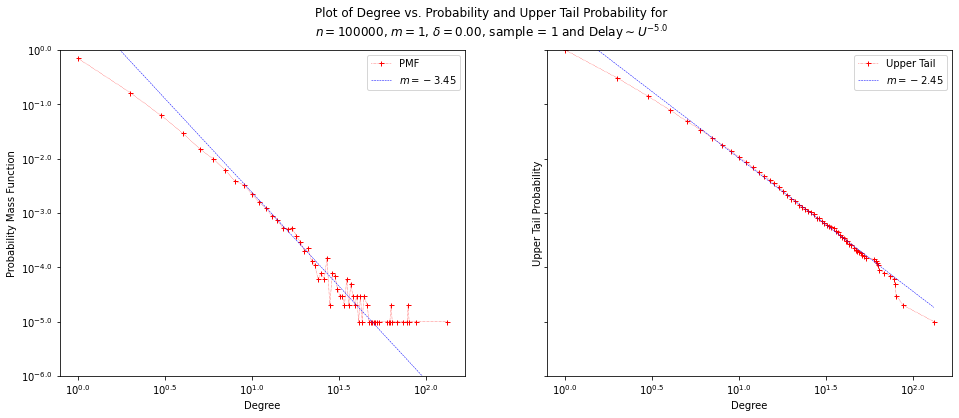

In [9]:
slope, nvals, G = run(N=100000, M=1, DELTA=0, A=-.2, SAMPLE_SIZE=1)

Time taken = 52.90 Seconds


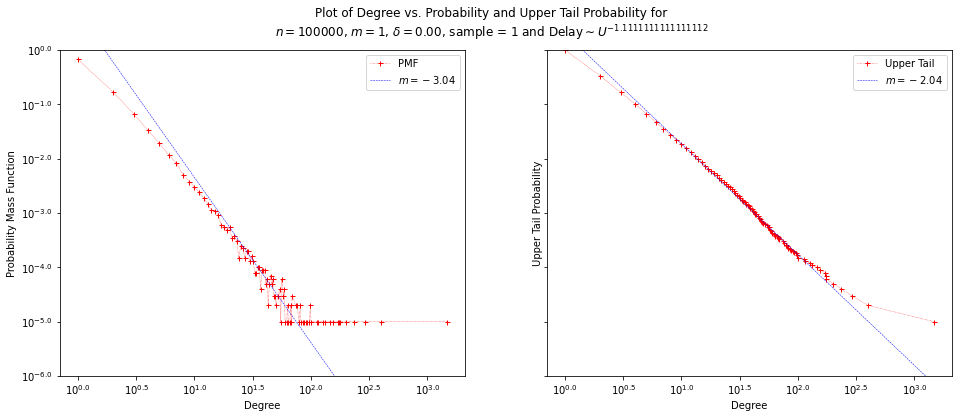

In [10]:
slope, nvals, G = run(N=100000, M=1, DELTA=0, A=-.9, SAMPLE_SIZE=1)

Time taken = 2.62 Seconds


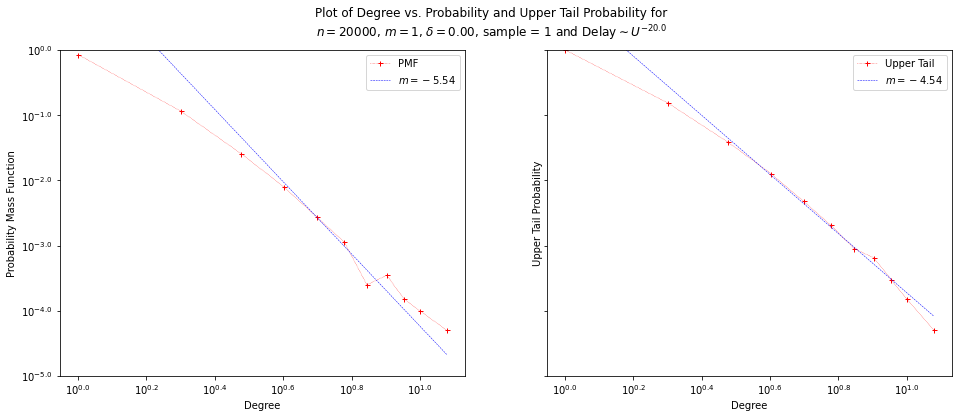

In [9]:
slope, nvals, G = run(N=20000, M=1, DELTA=0, A=-.05, SAMPLE_SIZE=1)

Time taken = 343.88 Seconds


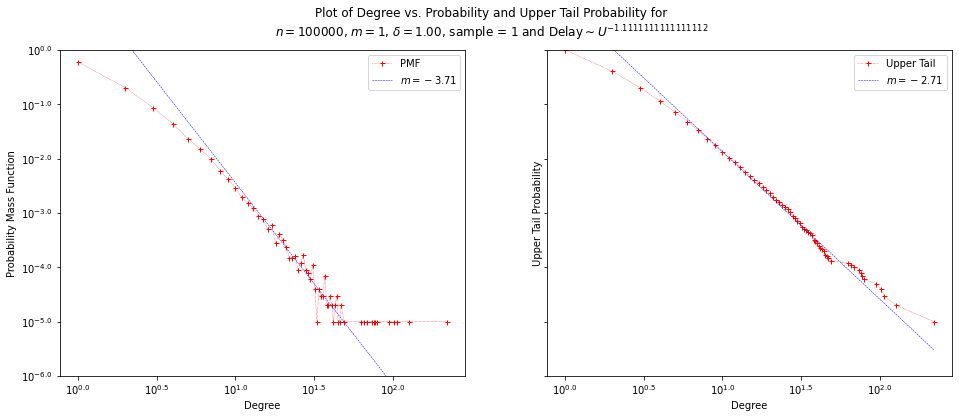

In [12]:
slope, nvals, G = run(N=100000, M=1, DELTA=1, A=-.9, SAMPLE_SIZE=1)

Time taken = 74.68 Seconds


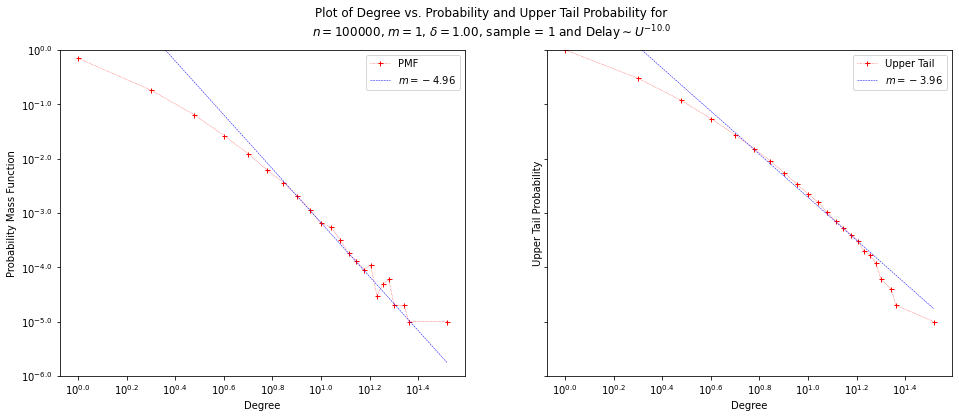

In [13]:
slope, nvals, G = run(N=100000, M=1, DELTA=1, A=-.1, SAMPLE_SIZE=1)

Time taken = 113.61 Seconds


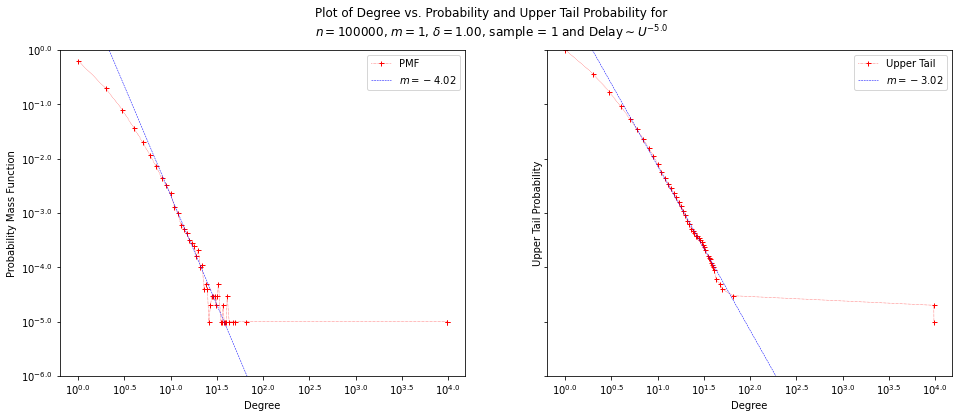

In [14]:
slope, nvals, G = run(N=100000, M=1, DELTA=1, A=-.2, SAMPLE_SIZE=1)

Time taken = 3.01 Seconds


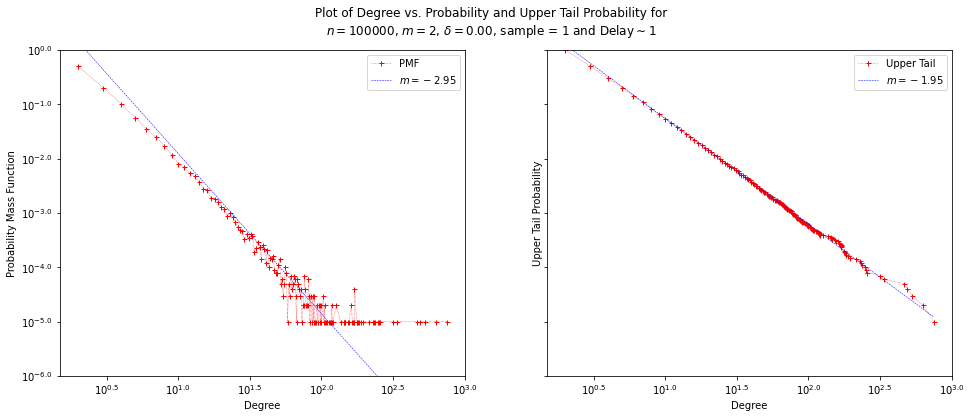

In [15]:
slope, nvals, G = run(N=100000, M=2, DELTA=0, A=1, SAMPLE_SIZE=1)

Time taken = 136.75 Seconds


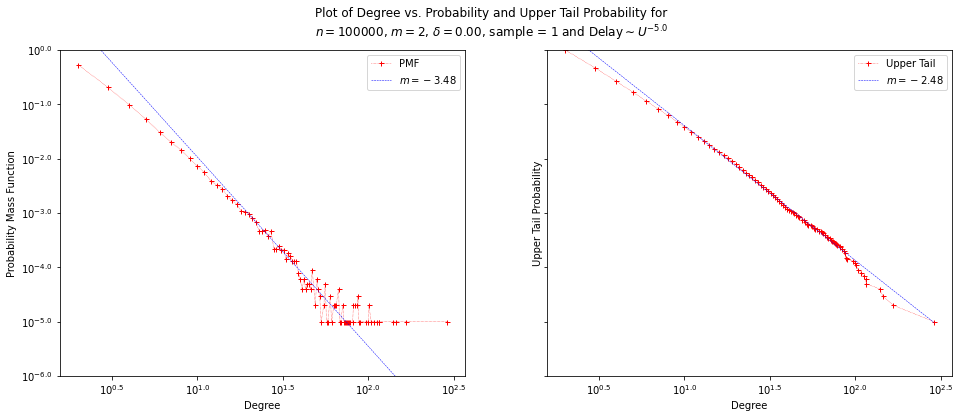

In [16]:
slope, nvals, G = run(N=100000, M=2, DELTA=0, A=-.2, SAMPLE_SIZE=1)

Time taken = 93.45 Seconds


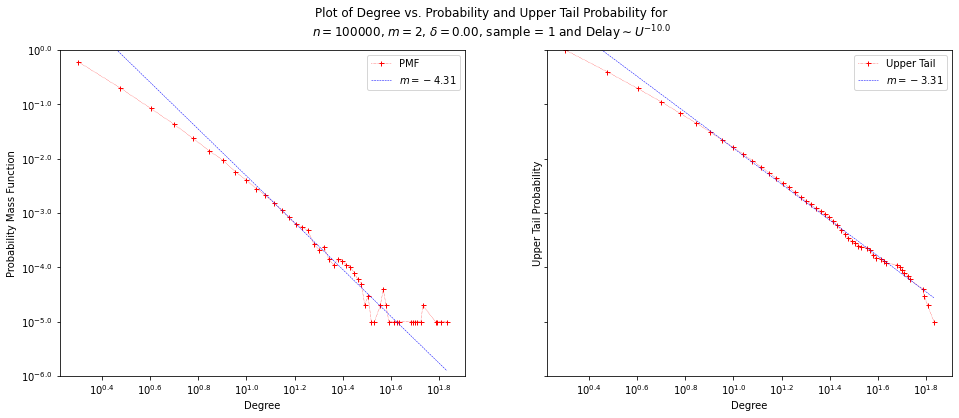

In [17]:
slope, nvals, G = run(N=100000, M=2, DELTA=0, A=-.1, SAMPLE_SIZE=1)

In [20]:
from google.colab import files

'''
from google.colab import drive
drive.mount('/drive')

with open('Colab Notebooks', 'w') as f:
    f.seek(0)
    f.truncate()
    nx.write_graphml(G, 'test.graphml')

files.download('test.graphml')
'''

nx.write_graphml(G, 'test.graphml')
files.download('test.graphml')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>